In [122]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 

In [123]:
#USER PARAM
input_path			=	'../../data/01-modified-data/twitter_text_data.csv'
compute_sentiment 	=	True		
sentiment    		=	[]			#average sentiment of each chunck of text 
ave_window_size		=	250			#size of scanning window for moving average
					

#OUTPUT FILE
output='transactions.txt'
if os.path.exists(output): os.remove(output)

#INITIALIZE
lemmatizer 	= 	WordNetLemmatizer()
ps 			=	PorterStemmer()
sia 		= 	SentimentIntensityAnalyzer()

#ADD MORE
stopwords	=	stopwords.words('english')
add=['mr','mrs','wa','dr','said','back','could','one','looked','like','know','around','dont', 'rt','', '1']
for sp in add: stopwords.append(sp)

def read_and_clean(path,START=0,STOP=-1):
	global sentiment 

	#-----------------------
	#INSERT CODE TO READ IN AS ONE BIG STING
	file = open(path, 'rt', encoding= 'utf-8')
	text = file.read().lower()
	file.close()
	#-----------------------

	#REMOVE HEADER, AND NEW LINES
	text=text.replace("'",'') #wasn't --> wasnt
	lines = text.splitlines(); text=''; 
	lines=lines[START:STOP]    # mystring.replace('\n', ' ')
	for line in lines: text=text+' '+line

	#-----------------------
	#INSERT CODE TO ONLY KEEP CHAR IN string.printable
	tmp = ''
	printable = set(string.printable)
	for char in text:
		if (char in printable ):
			tmp = tmp + char
		text = tmp
	#-----------------------

	#BREAK INTO CHUNKS (SENTANCES OR OTHERWISE)
	sentences=nltk.tokenize.sent_tokenize(text)  #SENTENCES

	print("NUMBER OF SENTENCES FOUND:",len(sentences)); #print(sentences)

	#CLEAN AND LEMMATIZE
	keep='0123456789abcdefghijklmnopqrstuvwxy';

	new_sentences=[]; vocabulary=[]
	for sentence in sentences:
		new_sentence=''

		# REBUILD LEMITIZED SENTENCE
		for word in sentence.split():
			
			#ONLY KEEP CHAR IN "keep"
			tmp2=''
			for char in word: 
				if(char in keep): 
					tmp2=tmp2+char
				else:
					tmp2=tmp2+' '
			word=tmp2

			#-----------------------
			# INSERT CODE TO LEMMATIZE THE WORDS
			new_word = lemmatizer.lemmatize(word)
			#-----------------------

			#REMOVE WHITE SPACES
			new_word=new_word.replace(' ', '')

			#BUILD NEW SENTANCE BACK UP
			if( new_word not in stopwords):
				if(new_sentence==''):
					new_sentence=new_word
				else:
					new_sentence=new_sentence+','+new_word
				if(new_word not in vocabulary): vocabulary.append(new_word)

		#SAVE (LIST OF LISTS)		
		new_sentences.append(new_sentence.split(","))
		
		#SIA
		if(compute_sentiment):
			#-----------------------
			# INSERT CODE TO USE NLTK TO DO SENTIMENT ANALYSIS 
			new_text= new_sentence.replace(',',' ')
			sentiment_level = sia.polarity_scores(new_text)
			sentiment.append([sentiment_level['neg'],sentiment_level['neu'],sentiment_level['pos'],sentiment_level['compound']])
			#-----------------------
			
		#SAVE SENTANCE TO OUTPUT FILE
		if(len(new_sentence.split(','))>2):
			f = open(output, "a")
			f.write(new_sentence+"\n")
			f.close()

	sentiment=np.array(sentiment)
	print("TOTAL AVERAGE SENTEMENT:",np.mean(sentiment,axis=0))
	print("VOCAB LENGTH",len(vocabulary))
	return new_sentences

transactions=read_and_clean(input_path,400,-400)
print(transactions[0:5])

NUMBER OF SENTENCES FOUND: 621
TOTAL AVERAGE SENTEMENT: [0.04147504 0.80044122 0.15648148 0.2132087 ]
VOCAB LENGTH 3616
[['enter', 'follow', 'bellycatsnft', 'monsterinhype', 'moonkillersnft', 'stussyjimin', 'park', 'tailor', 'chaos', 'jimin', 'coming', 'httpstcotc2yppqs', 'mutagensamurai', 'art', 'dead', '008eth', 'reserve', 'piece', 'decline', 'culture', 'modern', 'civilisation'], ['using', 'combination', 'good', 'drop', 'project', 'bjbaumann2014', 'monsterrafo', 'cdoug34', 'wild3eth', 'okaybroomer', 'precious7674', 'itsmijj', 'httpstcod3o88maudc', 'exterminatorgg', 'let', 'get', 'rid', 'animal', 'make', 'mess'], ['ape', 'go', 'moon'], ['exterminator', 'coming'], ['yfiusdt', 'yfi', 'signal', '2', 'last', 'signal', '109', 'min', 'ago', '847600000000', '855500000000', '093', 'volume', 'httpstconese5db5i', 'robinneth', 'robin', 'opentigers', 'giveaway', 'openw', 'nft', 'marketplace', 'first', 'nft', 'creation', 'join', 'purchase', 'opentiger', 'ethw', 'chai', 'new', 'ens', 'domain', 'reg

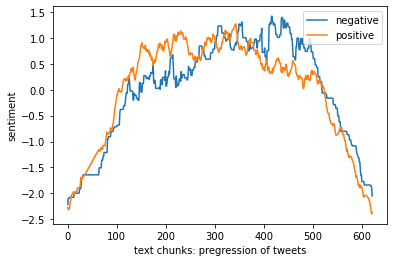

In [124]:
def moving_ave(y,w=100):
	#-----------------------
	# INSERT CODE TO COMPUTE THE MOVING AVERAGE OF A SIGNAL Y
	m_a = np.ones((1,w))/w
	m_a = m_a[0,:]
	return np.convolve(y, m_a, 'same')
	#-----------------------

# INSERT CODE TO VISUALIZE THE SENTIMENT ANALYSIS AS A TIME-SERIES (SEE PLOT FOR AN EXAMPLE)
if(compute_sentiment):
	neg = moving_ave(sentiment[:,0], ave_window_size)
	neg = (neg-np.mean(neg))/np.std(neg)
	
	nue = moving_ave(sentiment[:,1], ave_window_size)
	nue = (nue-np.mean(nue))/np.std(nue)
	
	compound = moving_ave(sentiment[:,2], ave_window_size)
	compound = (compound-np.mean(compound))/np.std(compound)

	pos = moving_ave(sentiment[:,3], ave_window_size)
	pos = (pos-np.mean(pos))/np.std(pos)

	index = np.linspace(0, len(sentiment), len(sentiment))
	plt.plot(index, neg, label = 'negative')
	plt.plot(index, pos, label = 'positive')

	plt.legend(loc = 'upper right')
	plt.xlabel('text chunks: pregression of tweets')
	plt.ylabel('sentiment')
	plt.show

In [125]:
# Re-format output
def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

In [126]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

In [130]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="white",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Tweet')
    plt.show()

In [131]:
#print(pd.DataFrame(transactions))

transactions_res = list(apriori(transactions,min_support = 0.083, min_confidence = 0.01, min_length = 1, max_length = 5))
print(len(transactions_res))

23


           rhs         lhs      supp      conf  supp x conf       lift
0        [amp]       [eth]  0.083736  0.666667     0.055824   2.287293
1        [eth]       [amp]  0.083736  0.287293     0.024057   2.287293
2        [amp]    [follow]  0.086957  0.692308     0.060201   4.432197
3     [follow]       [amp]  0.086957  0.556701     0.048409   4.432197
4        [btc]       [eth]  0.090177  0.674699     0.060842   2.314851
5        [eth]       [btc]  0.090177  0.309392     0.027900   2.314851
6        [eth]    [follow]  0.098229  0.337017     0.033105   2.157601
7     [follow]       [eth]  0.098229  0.628866     0.061773   2.157601
8        [eth]  [giveaway]  0.099839  0.342541     0.034199   2.127182
9   [giveaway]       [eth]  0.099839  0.620000     0.061900   2.127182
10        [go]      [moon]  0.083736  0.962963     0.080635  10.678571
11      [moon]        [go]  0.083736  0.928571     0.077755  10.678571
12       [let]      [make]  0.083736  0.787879     0.065974   7.413223
13    

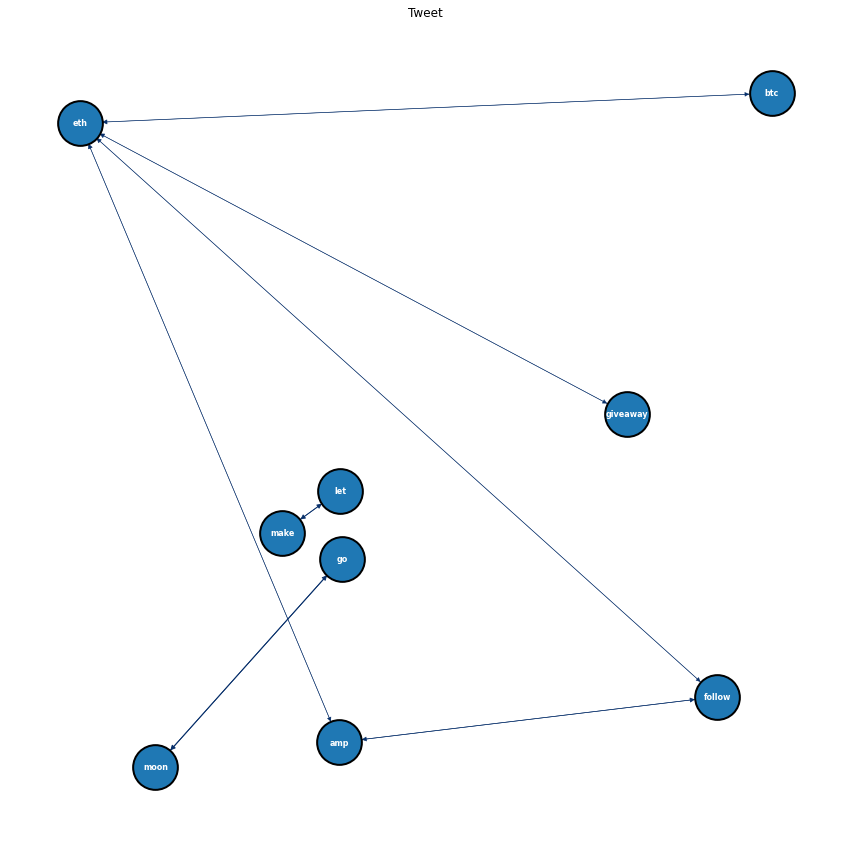

In [132]:
# INSERT CODE TO PLOT THE RESULTS AS A NETWORK-X OBJECT 
result = reformat_results(transactions_res)
network = convert_to_network(result)
plot_network(network)